In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing, metrics, svm, ensemble
from sklearn.metrics import accuracy_score, classification_report
import math
import seaborn as sns

In [20]:
stroke_df_initial = pd.read_csv(os.path.join('Resources/healthcare-dataset-stroke-data.csv'))
stroke_df_initial.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [21]:
#ID column is not necessary. Drop
stroke_df = stroke_df_initial.drop(['id'], axis = 1)
stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [22]:
#Checking for nulls
print(stroke_df.isna().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


201 rows of NA for bmi column only. Consider Drop NA but do complete data exploration first.

In [23]:
#Checking number of entries, data types
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [24]:
#Value counts for hypertension column to ensure only two choices
stroke_df["hypertension"].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

In [25]:
#Value counts for heart diseease column to ensure only two choices
stroke_df["heart_disease"].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

In [26]:
#Value counts for stroke column to ensure only two choices
stroke_df["stroke"].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [27]:
#Only 249 patients with stroke. How many will we lose if we Drop NA for the bmi column?
bmi_null_stroke = stroke_df.loc[(stroke_df['bmi'].isna() == True) & (stroke_df['stroke'] == 1)]
len(bmi_null_stroke)

40

40 is too many rows of valuable data to lose here. Consider other options. Insert mean into BMI? Other ideas?

In [28]:
#Check the value counts of all columns with datatype 'object' for a guide to encoding needs
counts = stroke_df.select_dtypes(include=object).columns.tolist()
(pd.DataFrame(
    stroke_df[counts]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))

counts
column         value                  
Residence_type Rural              2514
               Urban              2596
ever_married   No                 1757
               Yes                3353
gender         Other                 1
               Male               2115
               Female             2994
smoking_status smokes              789
               formerly smoked     885
               Unknown            1544
               never smoked       1892
work_type      Never_worked         22
               Govt_job            657
               children            687
               Self-employed       819
               Private            2925

Note that gender only has one 'other'; probably easier to remove that point for binary encoding. Note that one of the work_types is "children," meaning the dataset includes children. Look at age more closely.


In [29]:
#Examining age column
stroke_df.sort_values(by=['age']).head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3295,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
1614,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3618,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
3968,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0


This dataset even contains babies. Children are likely less useful in predicting stroke, although these particular children may have some other health issues, which is why they were included. How many children actually are labeled with stroke?

In [30]:
#Children stroke count
children_stroke = stroke_df.loc[(stroke_df['age'] < 17) & (stroke_df['stroke'] == 1)]
len(children_stroke)

2

Remove children from the dataset in this instance and compare model performance with the children data left in vs deleted.

In [31]:
#Removing children from the dataset

no_children_df = stroke_df[stroke_df.age > 16]
no_children_df.sort_values(by=['age'])


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
395,Female,17.0,0,0,No,Private,Urban,87.52,39.2,never smoked,0
3777,Female,17.0,0,0,No,Private,Rural,68.66,35.1,never smoked,0
4611,Female,17.0,0,0,No,Never_worked,Urban,78.08,44.9,never smoked,0
3256,Female,17.0,0,0,No,Private,Urban,89.58,22.8,Unknown,0
2128,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
4452,Female,82.0,1,0,Yes,Private,Urban,115.71,31.1,formerly smoked,0
42,Male,82.0,0,1,Yes,Private,Urban,144.90,26.4,smokes,1
2314,Male,82.0,0,0,Yes,Private,Urban,89.83,24.7,smokes,0
32,Female,82.0,1,0,Yes,Self-employed,Urban,196.92,22.2,never smoked,1


In [32]:
#Ensure children is no longer listed as a work type
no_children_df.sort_values(by=['age'])
no_children_df['work_type'].value_counts()

Private          2840
Self-employed     810
Govt_job          654
Never_worked       10
Name: work_type, dtype: int64

In [33]:
#Drop the 'other' row in gender column
cleaned_stroke_df = no_children_df[no_children_df.gender != 'Other']
cleaned_stroke_df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [34]:
# Use Pandas get_dummies to convert categorical data

encoded_df = pd.get_dummies(cleaned_stroke_df, columns=['gender','ever_married', 'Residence_type'])
encoded_df



,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,Private,228.69,36.6,formerly smoked,1,0,1,0,1,0,1
1,61.0,0,0,Self-employed,202.21,NaN,never smoked,1,1,0,0,1,1,0
2,80.0,0,1,Private,105.92,32.5,never smoked,1,0,1,0,1,1,0
3,49.0,0,0,Private,171.23,34.4,smokes,1,1,0,0,1,0,1
4,79.0,1,0,Self-employed,174.12,24.0,never smoked,1,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,Private,83.75,NaN,never smoked,0,1,0,0,1,0,1
5106,81.0,0,0,Self-employed,125.20,40.0,never smoked,0,1,0,0,1,0,1
5107,35.0,0,0,Self-employed,82.99,30.6,never smoked,0,1,0,0,1,1,0
5108,51.0,0,0,Private,166.29,25.6,formerly smoked,0,0,1,0,1,1,0


In [35]:
#Drop the extra dummies columns
encoded_stroke_df = encoded_df.drop(columns=['gender_Female','ever_married_No','Residence_type_Rural'])
encoded_stroke_df

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
0,67.0,0,1,Private,228.69,36.6,formerly smoked,1,1,1,1
1,61.0,0,0,Self-employed,202.21,NaN,never smoked,1,0,1,0
2,80.0,0,1,Private,105.92,32.5,never smoked,1,1,1,0
3,49.0,0,0,Private,171.23,34.4,smokes,1,0,1,1
4,79.0,1,0,Self-employed,174.12,24.0,never smoked,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,Private,83.75,NaN,never smoked,0,0,1,1
5106,81.0,0,0,Self-employed,125.20,40.0,never smoked,0,0,1,1
5107,35.0,0,0,Self-employed,82.99,30.6,never smoked,0,0,1,0
5108,51.0,0,0,Private,166.29,25.6,formerly smoked,0,1,1,0


In [36]:
#Label encode the categorical columns that have more than two choices
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
encoded_stroke_df['work_type']= label_encoder.fit_transform(encoded_stroke_df['work_type']) 
encoded_stroke_df.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
0,67.0,0,1,2,228.69,36.6,formerly smoked,1,1,1,1
1,61.0,0,0,3,202.21,NaN,never smoked,1,0,1,0
2,80.0,0,1,2,105.92,32.5,never smoked,1,1,1,0
3,49.0,0,0,2,171.23,34.4,smokes,1,0,1,1
4,79.0,1,0,3,174.12,24.0,never smoked,1,0,1,0


In [37]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Country'. 
encoded_stroke_df['smoking_status']= label_encoder.fit_transform(encoded_stroke_df['smoking_status']) 
encoded_stroke_df.head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
0,67.0,0,1,2,228.69,36.6,1,1,1,1,1
1,61.0,0,0,3,202.21,NaN,2,1,0,1,0
2,80.0,0,1,2,105.92,32.5,2,1,1,1,0
3,49.0,0,0,2,171.23,34.4,3,1,0,1,1
4,79.0,1,0,3,174.12,24.0,2,1,0,1,0


array([[<AxesSubplot:title={'center':'bmi'}>]], dtype=object)

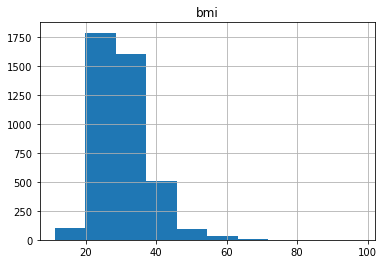

In [38]:
#Histogram of bmi column to view outliers
encoded_stroke_df.hist(column = 'bmi')

In [39]:
encoded_stroke_df.sort_values(by=['bmi'], ascending = False).head()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
2128,17.0,1,0,2,61.67,97.6,0,0,1,0,0
4209,38.0,1,0,2,56.90,92.0,2,0,1,1,0
928,23.0,1,0,2,70.03,78.0,3,0,0,0,1
544,42.0,0,0,2,210.48,71.9,2,0,1,1,0
1559,53.0,0,0,2,72.63,66.8,0,0,0,1,0


In [40]:
#Determine outliers using upper and lower bounds
quartiles = encoded_stroke_df['bmi'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq
lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
outliers = encoded_stroke_df.loc[(encoded_stroke_df['bmi'] < lower_bound) | (encoded_stroke_df['bmi'] > upper_bound)]
#Display upper & lower bounds and number of outliers
print(lower_bound)
print(upper_bound)
print(len(outliers))

12.349999999999994
47.150000000000006
117


In [41]:
#quick look at the data
encoded_stroke_df.describe()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
count,4313.000000,4313.000000,4313.000000,4313.000000,4313.000000,4130.000000,4313.000000,4313.000000,4313.000000,4313.000000,4313.00000
mean,49.745885,0.115465,0.063761,1.882217,108.226388,30.421719,1.570369,0.057269,0.394157,0.777417,0.50939
std,18.125129,0.319619,0.244355,0.884856,47.568050,7.323256,1.010025,0.232382,0.488726,0.416029,0.49997
min,17.000000,0.000000,0.000000,0.000000,55.120000,11.300000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,35.000000,0.000000,0.000000,2.000000,77.450000,25.400000,1.000000,0.000000,0.000000,1.000000,0.00000
50%,50.000000,0.000000,0.000000,2.000000,92.270000,29.200000,2.000000,0.000000,0.000000,1.000000,1.00000
75%,64.000000,0.000000,0.000000,2.000000,115.920000,34.100000,2.000000,0.000000,1.000000,1.000000,1.00000
max,82.000000,1.000000,1.000000,3.000000,271.740000,97.600000,3.000000,1.000000,1.000000,1.000000,1.00000


In [42]:
#Get the median values to compare mean and median in bmi
encoded_stroke_df.median()

age                     50.00
hypertension             0.00
heart_disease            0.00
work_type                2.00
avg_glucose_level       92.27
bmi                     29.20
smoking_status           2.00
stroke                   0.00
gender_Male              0.00
ever_married_Yes         1.00
Residence_type_Urban     1.00
dtype: float64

Mean and median are nearly identical. Either is an acceptable replacement.

In [43]:
#Set mean to a variable
mean_bmi = encoded_stroke_df['bmi'].mean()
mean_bmi

30.421719128329308

In [44]:
#replace NaN with mean bmi
replace_stroke_df = encoded_stroke_df.fillna(mean_bmi)
replace_stroke_df.tail()

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Male,ever_married_Yes,Residence_type_Urban
5105,80.0,1,0,2,83.75,30.421719,2,0,0,1,1
5106,81.0,0,0,3,125.20,40.000000,2,0,0,1,1
5107,35.0,0,0,3,82.99,30.600000,2,0,0,1,0
5108,51.0,0,0,2,166.29,25.600000,1,0,1,1,0
5109,44.0,0,0,0,85.28,26.200000,0,0,0,1,1


In [45]:
target = replace_stroke_df["stroke"]
target_names = ["0", "1"]

In [46]:
data = replace_stroke_df.drop("stroke", axis=1)
feature_names = data.columns
data

,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,gender_Male,ever_married_Yes,Residence_type_Urban
0,67.0,0,1,2,228.69,36.600000,1,1,1,1
1,61.0,0,0,3,202.21,30.421719,2,0,1,0
2,80.0,0,1,2,105.92,32.500000,2,1,1,0
3,49.0,0,0,2,171.23,34.400000,3,0,1,1
4,79.0,1,0,3,174.12,24.000000,2,0,1,0
...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,2,83.75,30.421719,2,0,1,1
5106,81.0,0,0,3,125.20,40.000000,2,0,1,1
5107,35.0,0,0,3,82.99,30.600000,2,0,1,0
5108,51.0,0,0,2,166.29,25.600000,1,1,1,0


In [47]:
#Model work starts here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [48]:
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [49]:
# Create the GridSearch estimator along with a parameter object containing the values to adjust
#from sklearn.model_selection import GridSearchCV
#param_grid = {'C': [1, 5, 10, 50],'gamma': [0.0001, 0.0005, 0.001, 0.005]}
#grid = GridSearchCV(model, param_grid, verbose=3)

In [50]:
#GridSearch Code
#grid.fit(X_train, y_train)

In [51]:
#GridSearch Code
#print(grid.best_params_)
# List the best score
#print(grid.best_score_)
# Make predictions with the hypertuned model
#predictions = grid.predict(X_test)

In [52]:
#GridSearch Code
#print('Test Acc: %.3f' % grid.score(X_test, y_test))

In [53]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1008
           1       0.00      0.00      0.00        71

    accuracy                           0.93      1079
   macro avg       0.47      0.50      0.48      1079
weighted avg       0.87      0.93      0.90      1079



C:\Users\betsy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# Model Accuracy for SVM
print('Test Acc: %.3f' % model.score(X_test, y_test))

Test Acc: 0.934


In [55]:
confusion_matrix = confusion_matrix(y_test,predictions)

<ipython-input-56-f02d75517392>:14: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_stroke = confusion_matrix[1,1] / sum(confusion_matrix[:,1])


Text(0.5, 1.0, 'Support Vector Machine Model')

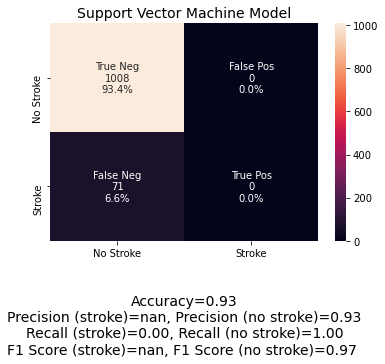

In [56]:
#Create an informative confusion matrix using seaborn
#Define variables for Information inside each box
category = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
counts = ['{0:0.0f}'.format(value) for value in confusion_matrix.flatten()]
percentages = ['{0:.1%}'.format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(category, counts, percentages)]
#Convert all of the labels to an array and reshape
labels = np.asarray(labels).reshape(2,2)
#Change the 0,1 to no stroke and stroke for labels
tick_labels = ['No Stroke', 'Stroke']
#Calculate all of the values to be displayed underneath the matrix as xlabel. Calculate precision, recall, F1 for both
#stroke and no stroke
accuracy  = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
precision_stroke = confusion_matrix[1,1] / sum(confusion_matrix[:,1])
recall_stroke    = confusion_matrix[1,1] / sum(confusion_matrix[1,:])
f1_score_stroke  = 2*precision_stroke*recall_stroke / (precision_stroke + recall_stroke)
precision = confusion_matrix[0,0] / sum(confusion_matrix[:,0])
recall    = confusion_matrix[0,0] / sum(confusion_matrix[0,:])
f1_score  = 2*precision*recall / (precision + recall)
#Set up the text for the x label display underneath the matrix
stats_text = "\n\nAccuracy={:0.2f}\nPrecision (stroke)={:0.2f}, Precision (no stroke)={:0.2f}\nRecall (stroke)={:0.2f}, Recall (no stroke)={:0.2f}\nF1 Score (stroke)={:0.2f}, F1 Score (no stroke)={:0.2f} ".format(accuracy,precision_stroke, precision, recall_stroke, recall, f1_score_stroke, f1_score)
#Make the seaborn heatmap
sns.heatmap(confusion_matrix, annot = labels, fmt = '', xticklabels = tick_labels, yticklabels = tick_labels)
plt.xlabel(stats_text, fontsize = 14)
plt.title("Support Vector Machine Model", fontsize = 14)